In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 630 ms, sys: 246 ms, total: 876 ms
Wall time: 1.92 s


In [4]:
%%time

task = 'classification'
dataset = create_dataset('movielens', sample_num=1000000, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 2.59 s, sys: 760 ms, total: 3.35 s
Wall time: 5.46 s


In [5]:
class NeuralCollaborativeFiltering(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(NeuralCollaborativeFiltering, self).__init__()
        self.embed1 = FeaturesEmbedding(field_dims, embed_dim)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        
        self.mlp = MultiLayerPerceptron([len(field_dims) * embed_dim, 128, 64])
        self.fc = nn.Linear(embed_dim + 64, 1)
        
    def forward(self, x):
        embeddings1 = self.embed1(x)
        gmf_output = embeddings1[:, 0].mul(embeddings1[:, 1]).squeeze(-1)
        
        embeddings2 = self.embed2(x)
        mlp_input = embeddings2.reshape(x.shape[0], -1)
        mlp_output = self.mlp(mlp_input)
        
        concated = torch.hstack([gmf_output, mlp_output])
        output = self.fc(concated)
        output = torch.sigmoid(output)
        return output


 18%|█▊        | 106/600 [00:11<00:53,  9.19it/s]


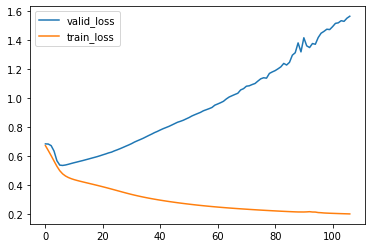

train_loss: 0.46550 | train_metric: 0.85316
valid_loss: 0.53598 | valid_metric: 0.78555
test_loss:  0.53254 | test_metric:  0.79464
CPU times: user 11.2 s, sys: 246 ms, total: 11.4 s
Wall time: 12 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

ncf = NeuralCollaborativeFiltering(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(ncf.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(ncf, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
